
#### Running a few different NLP models to understand customer concerns in the ski industry.

#### Questions:


### Imports

In [3]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from transformers import pipeline
from summa import keywords
from collections import Counter
import wordcloud as WordCloud
import multiprocessing
import pickle


### Loading Dataset

In [4]:

# Read the CSV file
#file_path = 'C:/Users/johne/Downloads/OnTheSnow_SkiAreaReviews.csv'
file_path = 'C:/Users/matt/Downloads/OnTheSnow_SkiAreaReviews.csv'
skiraw = pd.read_csv(file_path)

# Display the first few rows of the new DataFrame to verify
print(skiraw.head())

   Unnamed: 0       State          Ski Area  Reviewer Name  \
0           0  california  squaw-valley-usa  philip sayles   
1           1  california  squaw-valley-usa    mateonelson   
2           2  california  squaw-valley-usa            NaN   
3           3  california  squaw-valley-usa   Ivan Cazares   
4           4  california  squaw-valley-usa        welzbob   

          Review Date  Review Star Rating (out of 5)  \
0  31st December 2019                              3   
1       22nd May 2019                              4   
2      7th March 2019                              2   
3      5th March 2019                              3   
4  26th February 2019                              3   

                                         Review Text  
0  I'm glad our family experienced Squaw but I wo...  
1  I went skiing today 5/22, granite chief was am...  
2  We had a horrible experience on our family ski...  
3  This is the first year I ski Squaw. I've been ...  
4  Both Squaw a

### Cleaning Data

In [5]:
# Check for null values
null_values = skiraw.isnull().sum()
print("Null values in each column:\n", null_values)

# Remove reviews without text because this is NLP based
ski_cleaned = skiraw.dropna(subset=['Review Text'])

# Check for Null values again
null_values = ski_cleaned.isnull().sum()
print("Null values in each column:\n", null_values)

# Convert review text column to string
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str)

# Verify the conversion
print(ski_cleaned['Review Text Cleaned'].dtype)


Null values in each column:
 Unnamed: 0                         0
State                              0
Ski Area                           0
Reviewer Name                    109
Review Date                        0
Review Star Rating (out of 5)      0
Review Text                       12
dtype: int64
Null values in each column:
 Unnamed: 0                         0
State                              0
Ski Area                           0
Reviewer Name                    109
Review Date                        0
Review Star Rating (out of 5)      0
Review Text                        0
dtype: int64
object


C:\Users\matt\AppData\Local\Temp\ipykernel_21508\520097311.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str)


## Visualizing Raw Data

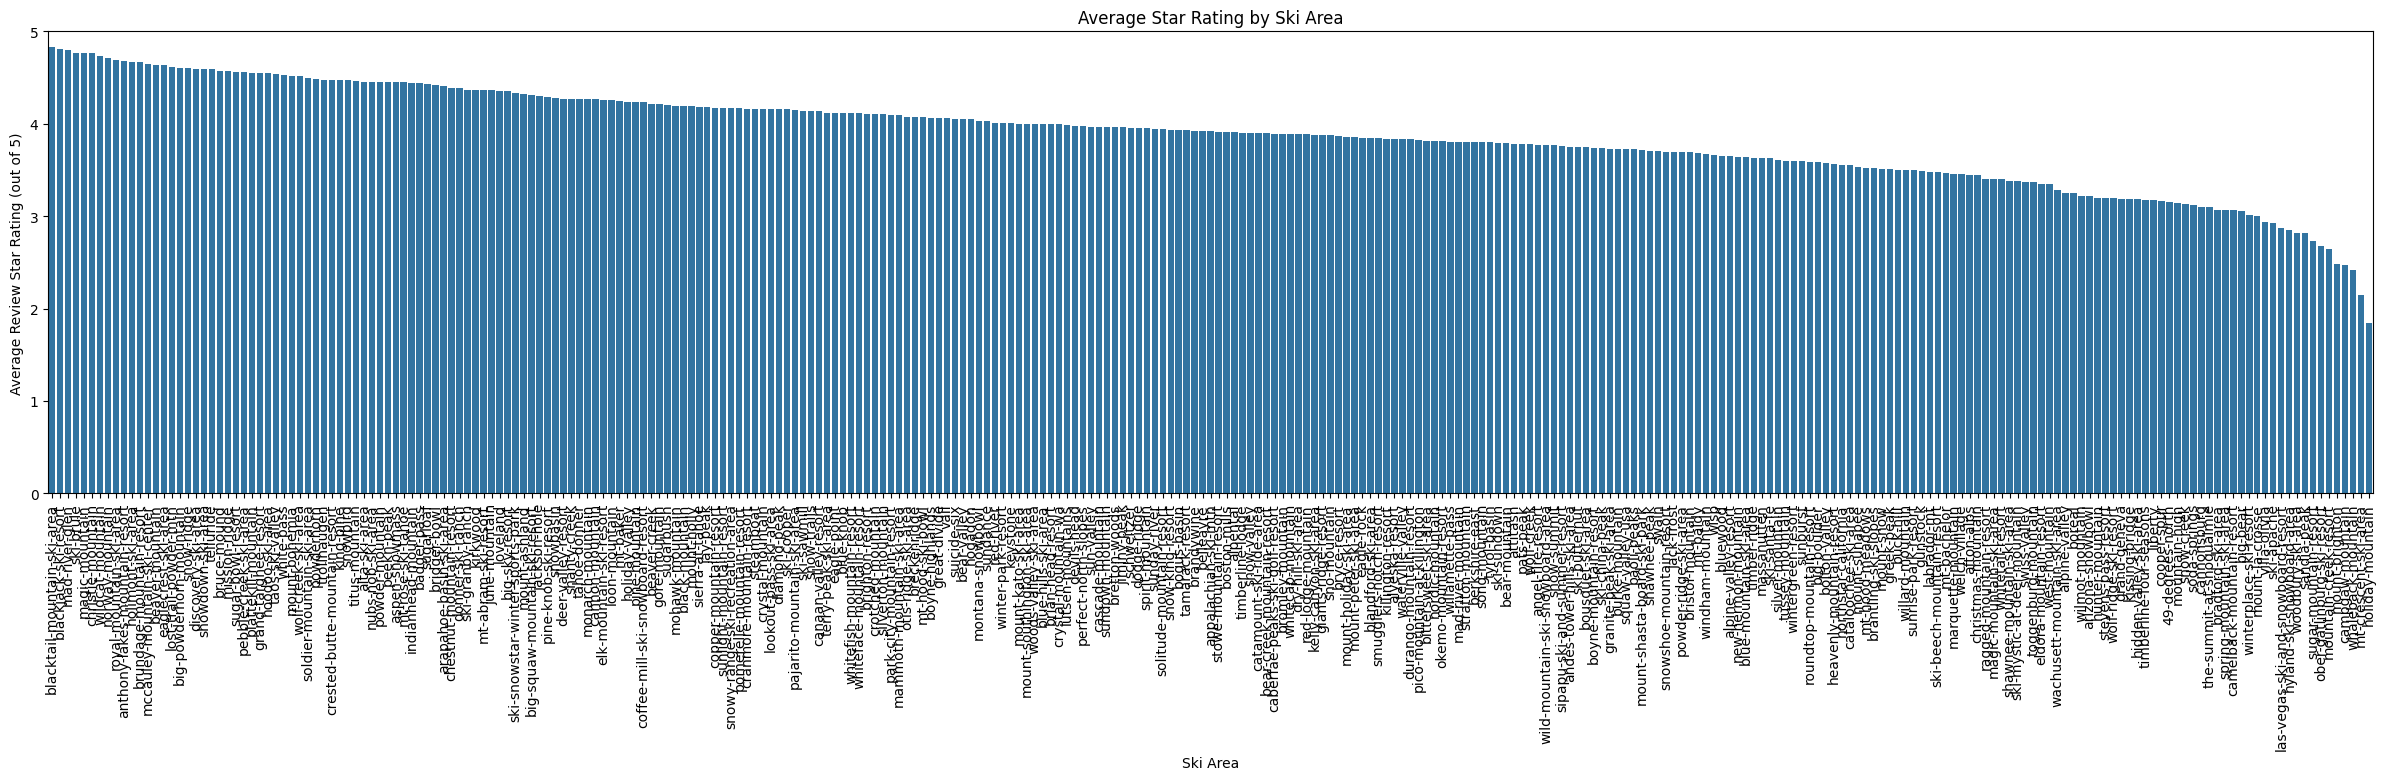

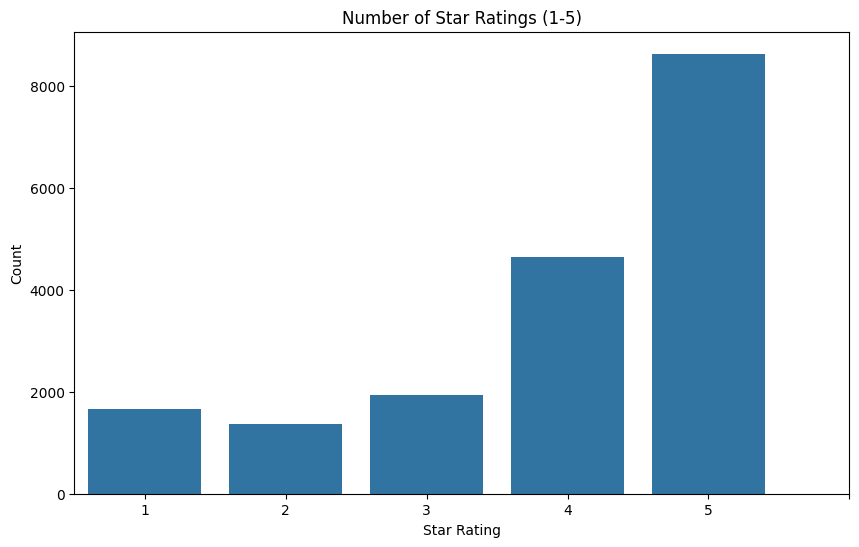

In [6]:
# Bar plot for the average star rating by ski area, sorted by descending order
plt.figure(figsize=(30, 6))
average_ratings = ski_cleaned.groupby('Ski Area')['Review Star Rating (out of 5)'].mean().reset_index()
average_ratings = average_ratings.sort_values(by='Review Star Rating (out of 5)', ascending=False)
sns.barplot(data=average_ratings, x='Ski Area', y='Review Star Rating (out of 5)')
plt.title('Average Star Rating by Ski Area')
plt.xlabel('Ski Area')
plt.ylabel('Average Review Star Rating (out of 5)')
plt.ylim(0, 5)
plt.xticks(rotation=90)
plt.show()

# Plot the number of star ratings from 1 to 5
plt.figure(figsize=(10, 6))
sns.countplot(data=ski_cleaned, x='Review Star Rating (out of 5)')
plt.title('Number of Star Ratings (1-5)')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])
plt.show()

### Takeaways
- Every ski resort has an average of above 2 stars
- The distibution of review star ratings leans heavily towards positive ratings

## Extracting Positive and Negative Features Using Sentiment Analysis

### Pre processing data for sentiment Analysis

In [8]:

# Clean Data
ski_cleaned = skiraw.copy()
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str).str.replace('[^\\w\\s]', '', regex=True)
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('\\d+', '', regex=True)
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.lower()


# Remove stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Tokenize and Lemmatize text
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

ski_cleaned['tokens'] = ski_cleaned['Review Text Cleaned'].apply(word_tokenize)
ski_cleaned['tokens'] = ski_cleaned['tokens'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x])
ski_cleaned['final_text'] = ski_cleaned['tokens'].apply(lambda x: ' '.join(x))




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\matt\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matt\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Running Seniment On Tokens using pre-trained model for labeling

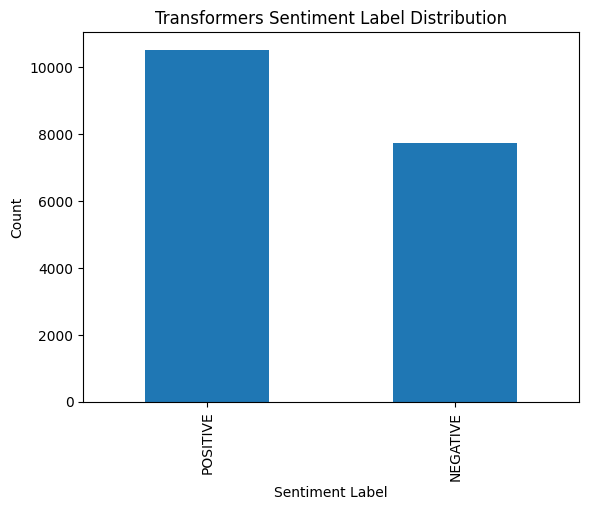

In [9]:


# Truncate reviews to 395 tokens, in a production setting this may cause inaccuracies
max_length = 395
ski_cleaned['truncated_text'] = ski_cleaned['final_text'].apply(lambda x: ' '.join(x.split()[:max_length]))

# Sentiment Analysis
from transformers import pipeline

# Specify the model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

# Apply sentiment analysis to the cleaned review text
ski_cleaned['transformers_sentiment'] = ski_cleaned['truncated_text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Extract negative and positive reviews
negative_reviews = ski_cleaned[ski_cleaned['transformers_sentiment'] == 'NEGATIVE']
positive_reviews = ski_cleaned[ski_cleaned['transformers_sentiment'] == 'POSITIVE']

# Save the processed DataFrame
with open('ski_cleaned.pkl', 'wb') as file:
    pickle.dump(ski_cleaned, file)

# Display sentiment label distribution for Transformers
ski_cleaned['transformers_sentiment'].value_counts().plot(kind='bar')
plt.title('Transformers Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()



### Counting number of skiing related keywords in text while considering next steps

In [10]:


# Occurances of word associated with chairlift

# Define the words you want to count
words_to_count = ["chairlift", "chair"]

# Function to count occurrences of words in a string
def count_words_occurrences(text, words):
    return sum(text.split().count(word) for word in words)

# Count occurrences of the words in the 'final_text' column
total_count = ski_cleaned['final_text'].apply(lambda x: count_words_occurrences(x, words_to_count)).sum()

# Print the result
print(f"The words {words_to_count} occur {total_count} times in the 'final_text' column.")

# Function to count occurrences of a word in a string
def count_word_occurrences(text, word):
    return text.split().count(word)

# Occurances of the word food

# Apply the function to the 'final_text' column and sum the results
word_count_food = ski_cleaned['final_text'].apply(lambda x: count_word_occurrences(x, "food")).sum()

print(f"The word '{"food"}' occurs {word_count_food} times in the 'final_text' column.")


# Occurances of the word Hotel

# Apply the function to the 'final_text' column and sum the results
word_count_skiing = ski_cleaned['final_text'].apply(lambda x: count_word_occurrences(x, "hotel")).sum()

print(f"The word '{"hotel"}' occurs {word_count_food} times in the 'final_text' column.")


# Occurances of the word skiing

# Apply the function to the 'final_text' column and sum the results
word_count_skiing = ski_cleaned['final_text'].apply(lambda x: count_word_occurrences(x, "skiing")).sum()

print(f"The word '{"skiing"}' occurs {word_count_skiing} times in the 'final_text' column.")


The words ['chairlift', 'chair'] occur 2168 times in the 'final_text' column.
The word 'food' occurs 2549 times in the 'final_text' column.
The word 'hotel' occurs 2549 times in the 'final_text' column.
The word 'skiing' occurs 7838 times in the 'final_text' column.


### Conducting Keyword Extraction on Negative and Positive reviews seperately to gain insight

In [ ]:


# Keyword Extraction using TextRank
from summa import keywords
from collections import Counter

def extract_keywords(reviews):
    reviews['keywords'] = reviews['final_text'].apply(lambda x: keywords.keywords(x).split('\n'))
    all_keywords = [keyword for sublist in reviews['keywords'] for keyword in sublist]
    keyword_freq = Counter(all_keywords)
    keywords_df = pd.DataFrame(keyword_freq.items(), columns=['keyword', 'count']).sort_values(by='count', ascending=False)
    return keywords_df

# Extract keywords from negative and positive reviews
keywords_df_neg = extract_keywords(negative_reviews)
keywords_df_pos = extract_keywords(positive_reviews)

# Display the top 20 keywords
print("Top Keywords from Negative Sentiment by TextRank")
print(keywords_df_neg.head(20))

print("Top Keywords from Positive Sentiment by TextRank")
print(keywords_df_pos.head(20))



NameError: name 'negative_reviews' is not defined

In [ ]:
#Loading processed file
with open('ski_cleaned.pkl', 'rb') as file:
    ski_cleaned = pickle.load(file)


ski_cleaned.head

<bound method NDFrame.head of        Unnamed: 0          State            Ski Area  Reviewer Name  \
0               0     california    squaw-valley-usa  philip sayles   
1               1     california    squaw-valley-usa    mateonelson   
2               2     california    squaw-valley-usa            NaN   
3               3     california    squaw-valley-usa   Ivan Cazares   
4               4     california    squaw-valley-usa        welzbob   
...           ...            ...                 ...            ...   
18257       18257  new-hampshire  whaleback-mountain       Matthijs   
18258       18258  new-hampshire  whaleback-mountain          Dolly   
18259       18259  new-hampshire  whaleback-mountain          Roger   
18260       18260  new-hampshire  whaleback-mountain         Arthur   
18261       18261  new-hampshire  whaleback-mountain    David  Cook   

              Review Date  Review Star Rating (out of 5)  \
0      31st December 2019                              3 

### Consider using zero-shot classification for finding which popular topics have the most negative sentiment

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

# Define the model name
model_name = "deepset/tinyroberta-squad2"

# Load model and tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set up the question-answering pipeline
nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

# Define the question and context
QA_input = {
    'question': 'What aspects of the ski area are most negative reviews written about?',
    'context': ski_cleaned['final_text']  # Ensure ski_cleaned['final_text'] is defined elsewhere in your code
}

# Get predictions
res = nlp(QA_input)

# Output the result
print(res)



TypeError: ord() expected a character, but string of length 600 found